In [1]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

v_f = float(config['tdr']['v_f']) #velocity factor

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

### 5.32 m
Short circuit at 5.32 m from the input port

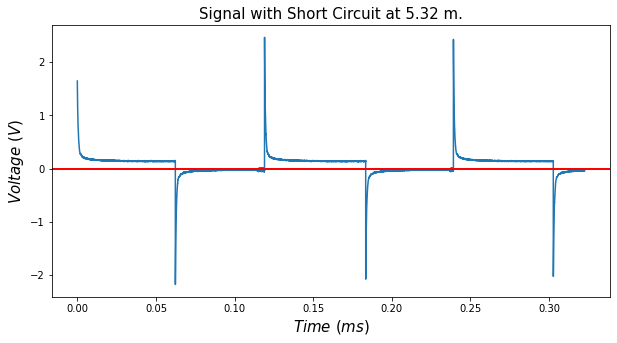

In [3]:
short_5m_files_dir = './data/short-circuit/5m'

#load a random file
v_short_5m = ut.random_file_load(short_5m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_5m, 'Signal with Short Circuit at 5.32 m.')

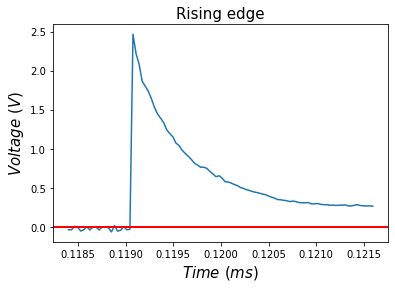

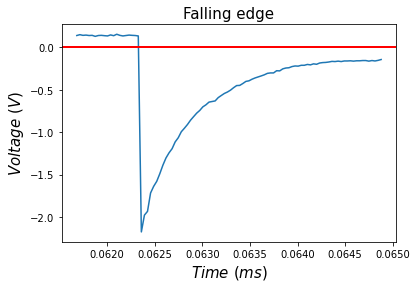

In [4]:
#locate rising a rising edge and a falling edge in the signal
short_5m_edges_indices = ut.edges_detection(v_short_5m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_5m, t, short_5m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

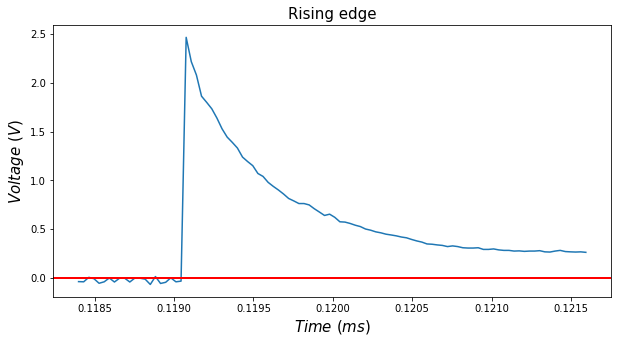

In [5]:
rising_edge_indx = short_5m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_5m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)


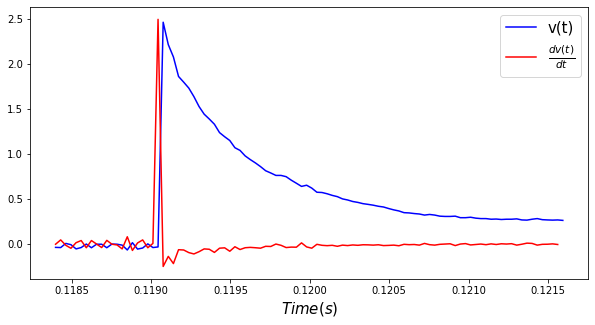

In [6]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

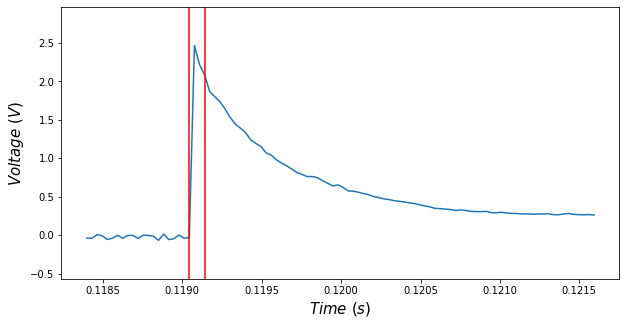

Timed delay is 9.678387193559623e-05 ms


In [7]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [8]:
p_rising_fault = ut.fault_point(t_rising_delay, v_f)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 13.957202171832332 m


#### 2. Falling edge

Change point detection on a falling edge

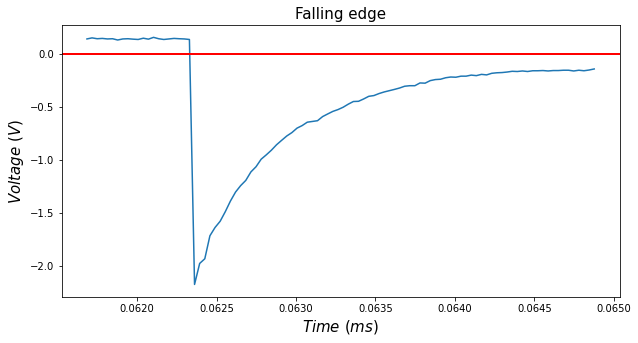

In [9]:
falling_edge_indx = short_5m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_5m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

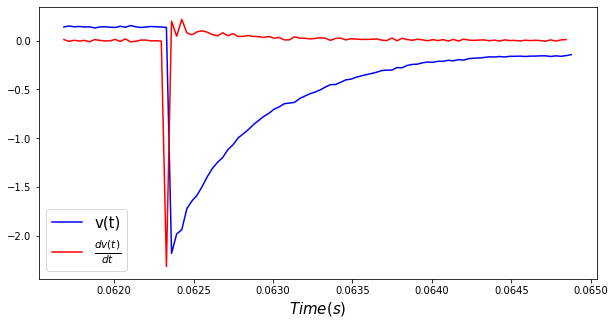

In [10]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

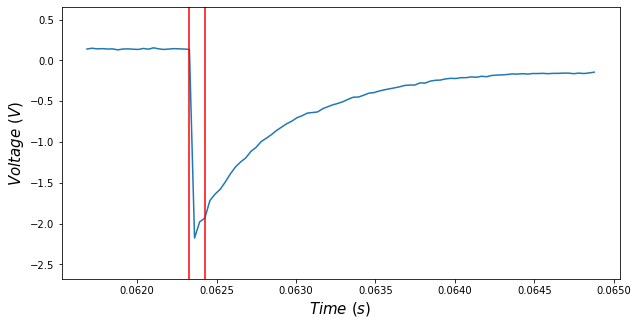

Timed delay is 9.67838719355893e-05 ms


In [11]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

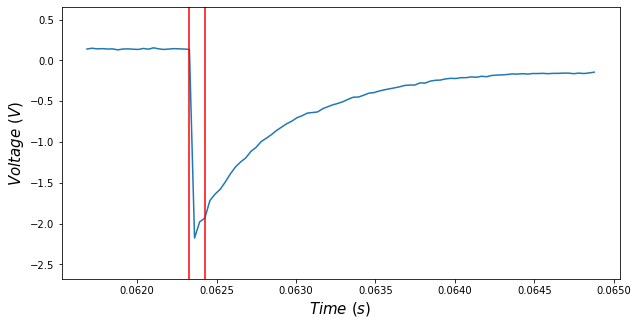

Timed delay is 9.67838719355893e-05 ms


In [12]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [13]:
p_falling_fault = ut.fault_point(t_falling_delay, v_f)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 13.957202171831332 m


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [14]:
#locate rising rising edges and a falling edges in the signal
short_5m_edges_indices = ut.edges_detection(v_short_5m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_5m_edges_indices)

{'rising_edges': [7413, 3690], 'falling_edges': [1932, 5684, 9382]}


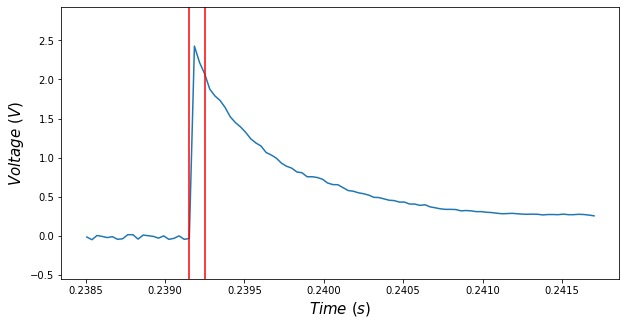

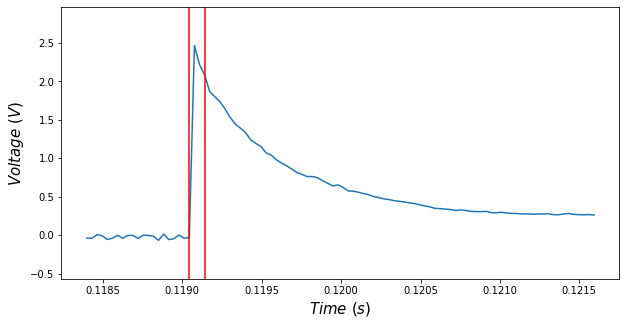

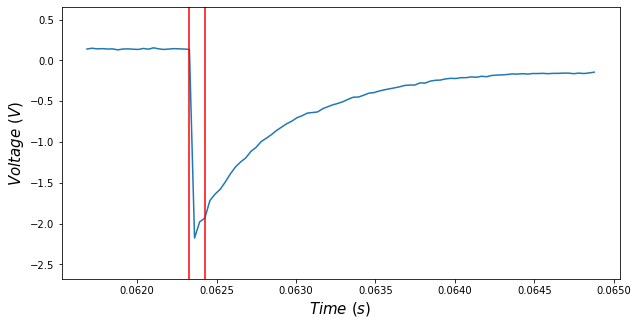

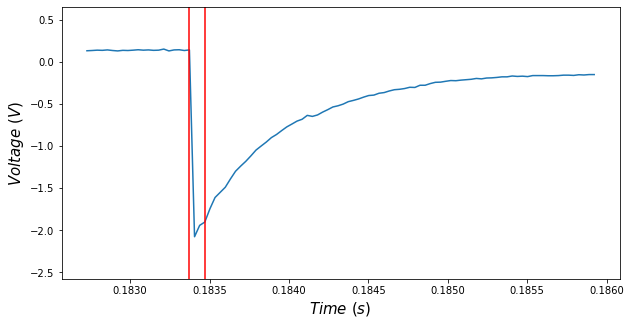

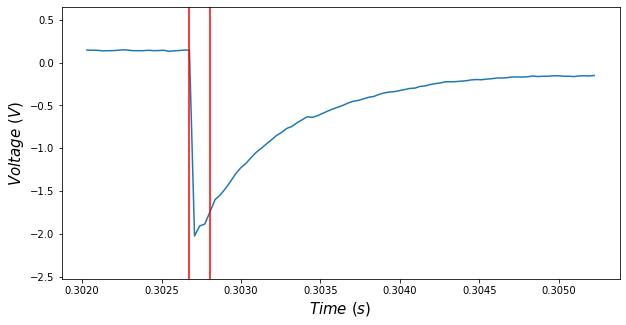

[9.67838719e-05 9.67838719e-05 9.67838719e-05 9.67838719e-05
 1.29045163e-04]
Average time delay is 0.00010323613006462534 ms


In [15]:
avg_t_short_5m_delay,  t_short_5m_delays = ut.avg_delay(short_5m_edges_indices, win_size, v_short_5m, t, prior_samples)

print(t_short_5m_delays)
print('Average time delay is {} ms'.format(avg_t_short_5m_delay))

In [16]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_5m_delay, v_f)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 14.887682316619621 m


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [17]:
short_5m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
paths = ut.file_paths(short_5m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_5m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_5m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_5m_edges_indices = ut.edges_detection(v_short_5m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_5m_delay,  t_short_5m_delays = ut.avg_delay(short_5m_edges_indices, win_size, v_short_5m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_5m_delay, v_f)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_5m_delay)
        distance_to_fault.append(p_short_fault)
        
short_5m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_5m = pd.DataFrame(short_5m_circuit_files)
        
df_short_5m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/5m/short-107-5-1.csv,0.000103,14.887682
1,./data/short-circuit/5m/short-107-5-10.csv,0.000108,15.508002
2,./data/short-circuit/5m/short-107-5-11.csv,0.000105,15.120302
3,./data/short-circuit/5m/short-107-5-12.csv,0.000103,14.887682
4,./data/short-circuit/5m/short-107-5-13.csv,0.000097,13.957202
5,./data/short-circuit/5m/short-107-5-14.csv,0.000097,13.957202
6,./data/short-circuit/5m/short-107-5-15.csv,0.000110,15.818162
7,./data/short-circuit/5m/short-107-5-16.csv,0.000097,13.957202
8,./data/short-circuit/5m/short-107-5-17.csv,0.000103,14.887682
9,./data/short-circuit/5m/short-107-5-18.csv,0.000116,16.748643


### 8.52 m
Short circuit at 8.52 m from the input port

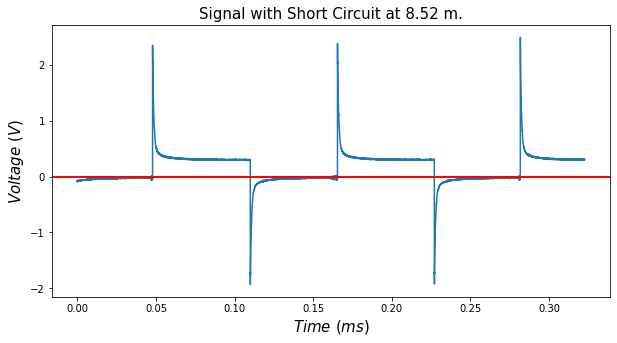

In [18]:
short_9m_files_dir = './data/short-circuit/9m'

#load a random file
v_short_9m = ut.random_file_load(short_9m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_9m, 'Signal with Short Circuit at 8.52 m.')

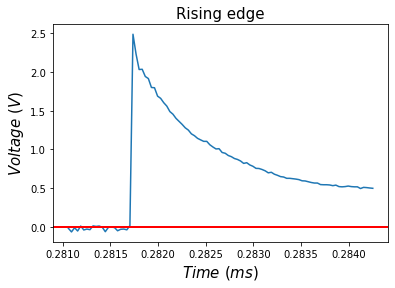

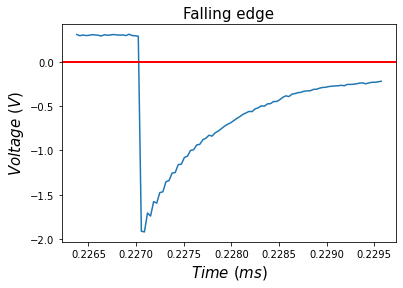

In [19]:
#locate rising a rising edge and a falling edge in the signal
short_9m_edges_indices = ut.edges_detection(v_short_9m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_9m, t, short_9m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

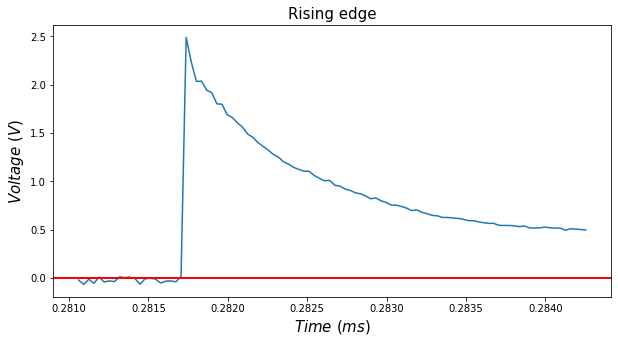

In [20]:
rising_edge_indx = short_9m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_9m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

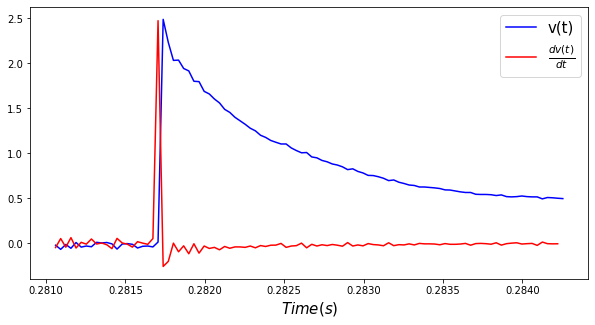

In [21]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

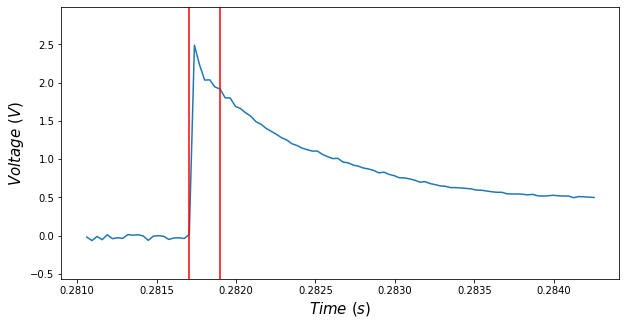

Timed delay is 0.00019356774387113695 ms


In [22]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [23]:
p_rising_fault = ut.fault_point(t_rising_delay, v_f)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 27.91440434365666 m


#### 2. Falling edge

Change point detection on a falling edge

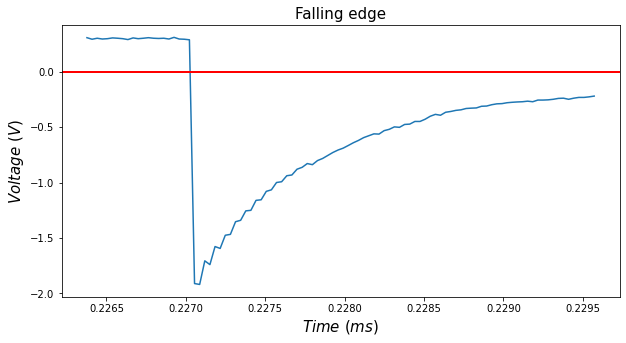

In [24]:
falling_edge_indx = short_9m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_9m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

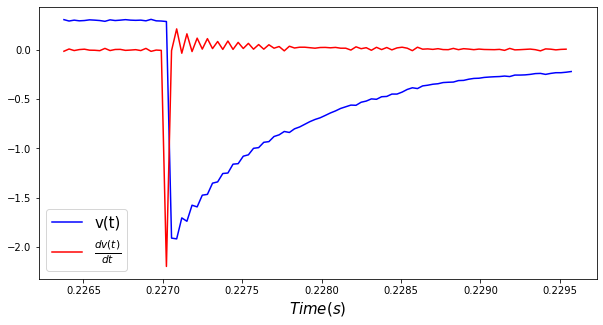

In [25]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

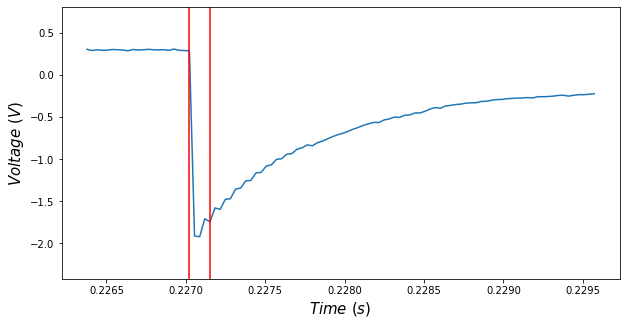

Timed delay is 0.00012904516258077647 ms


In [26]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [27]:
p_falling_fault = ut.fault_point(t_falling_delay, v_f)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 18.609602895773776 m


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [28]:
#locate rising rising edges and a falling edges in the signal
short_9m_edges_indices = ut.edges_detection(v_short_9m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_9m_edges_indices)

{'rising_edges': [1483, 5128, 8732], 'falling_edges': [7037, 3409]}


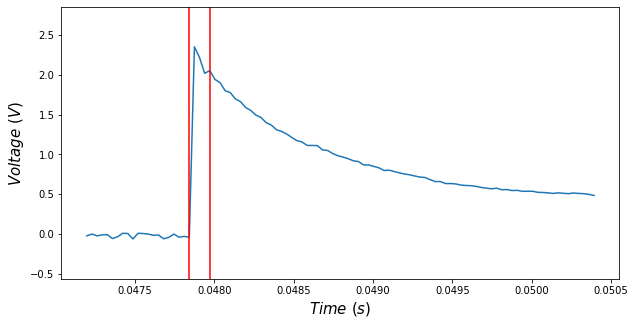

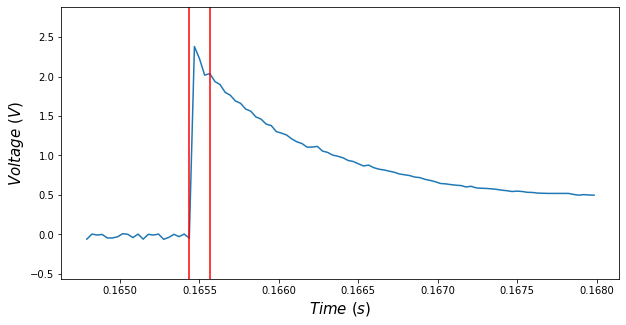

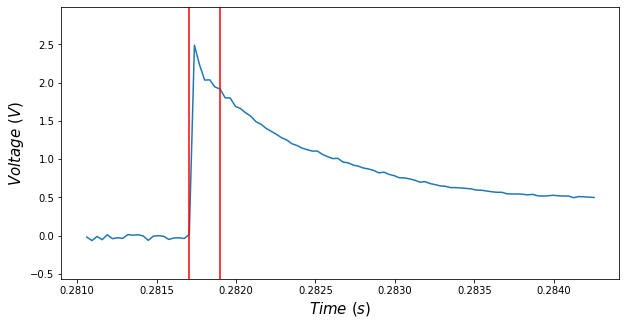

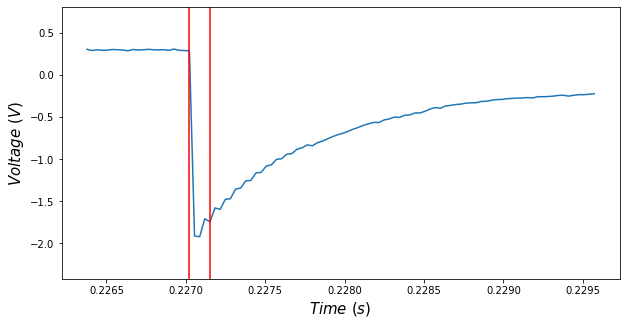

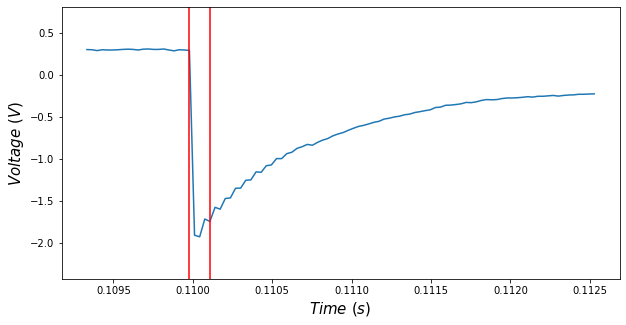

[0.00012905 0.00012905 0.00019357 0.00012905 0.00012905]
Average time delay is 0.00014194967883884163 ms


In [29]:
avg_t_short_9m_delay,  t_short_9m_delays = ut.avg_delay(short_9m_edges_indices, win_size, v_short_9m, t, prior_samples)

print(t_short_9m_delays)
print('Average time delay is {} ms'.format(avg_t_short_9m_delay))

In [30]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_9m_delay, v_f)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 20.470563185349352 m


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [31]:
short_9m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
paths = ut.file_paths(short_9m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_9m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_9m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_9m_edges_indices = ut.edges_detection(v_short_9m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_9m_delay,  t_short_9m_delays = ut.avg_delay(short_9m_edges_indices, win_size, v_short_9m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_9m_delay, v_f)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_9m_delay)
        distance_to_fault.append(p_short_fault)
        
short_9m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_9m = pd.DataFrame(short_9m_circuit_files)
        
df_short_9m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/9m/short-107-9-1.csv,0.000186,26.751304
1,./data/short-circuit/9m/short-107-9-10.csv,0.000142,20.470563
2,./data/short-circuit/9m/short-107-9-11.csv,0.000142,20.470563
3,./data/short-circuit/9m/short-107-9-12.csv,0.000174,25.122964
4,./data/short-circuit/9m/short-107-9-13.csv,0.000129,18.609603
5,./data/short-circuit/9m/short-107-9-14.csv,0.000140,20.160403
6,./data/short-circuit/9m/short-107-9-15.csv,0.000142,20.470563
7,./data/short-circuit/9m/short-107-9-16.csv,0.000135,19.540083
8,./data/short-circuit/9m/short-107-9-17.csv,0.000142,20.470563
9,./data/short-circuit/9m/short-107-9-18.csv,0.000145,20.935803
